**Audio Enhancement Comparison Analysis**

This notebook compares an original audio file with its enhanced version using various metrics and visualizations.

In [ ]:
pip install pandas seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy import signal
from sklearn.metrics import mean_squared_error
import pandas as pd
import seaborn as sns

In [12]:
from pathlib import Path
import os
import sys
import pathlib

In [13]:
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
sys.path.append(data_path)

In [14]:
# pip install seaborn

In [15]:
# Load audio files
original_path =data_path+r'\audio\recorded_audio.wav'
enhanced_path = data_path+r'\audio\enhanced_audio.wav'

In [16]:
print(os.path.exists(original_path))
print(original_path)

True
d:\PERSONAL\GitHub\College\MOTIVE\backend\data\audio\recorded_audio.wav


In [17]:
original, sr_orig = torchaudio.load(original_path)
enhanced, sr_enh = torchaudio.load(enhanced_path)

In [18]:
# Ensure sample rates match
assert sr_orig == sr_enh, "Sample rates must match!"

In [19]:
# Convert to mono if needed
if original.shape[0] > 1:
    original = torch.mean(original, dim=0)
if enhanced.shape[0] > 1:
    enhanced = torch.mean(enhanced, dim=0)

In [20]:
# Trim to same length
min_len = min(original.shape[-1], enhanced.shape[-1])
original = original[..., :min_len]
enhanced = enhanced[..., :min_len]

In [21]:
# Convert to numpy
original_np = original.numpy().squeeze()
enhanced_np = enhanced.numpy().squeeze()

In [22]:
# Audio playback
print("Original Audio:")
ipd.display(ipd.Audio(original_np, rate=sr_orig))
print("Enhanced Audio:")
ipd.display(ipd.Audio(enhanced_np, rate=sr_orig))

Original Audio:


Enhanced Audio:


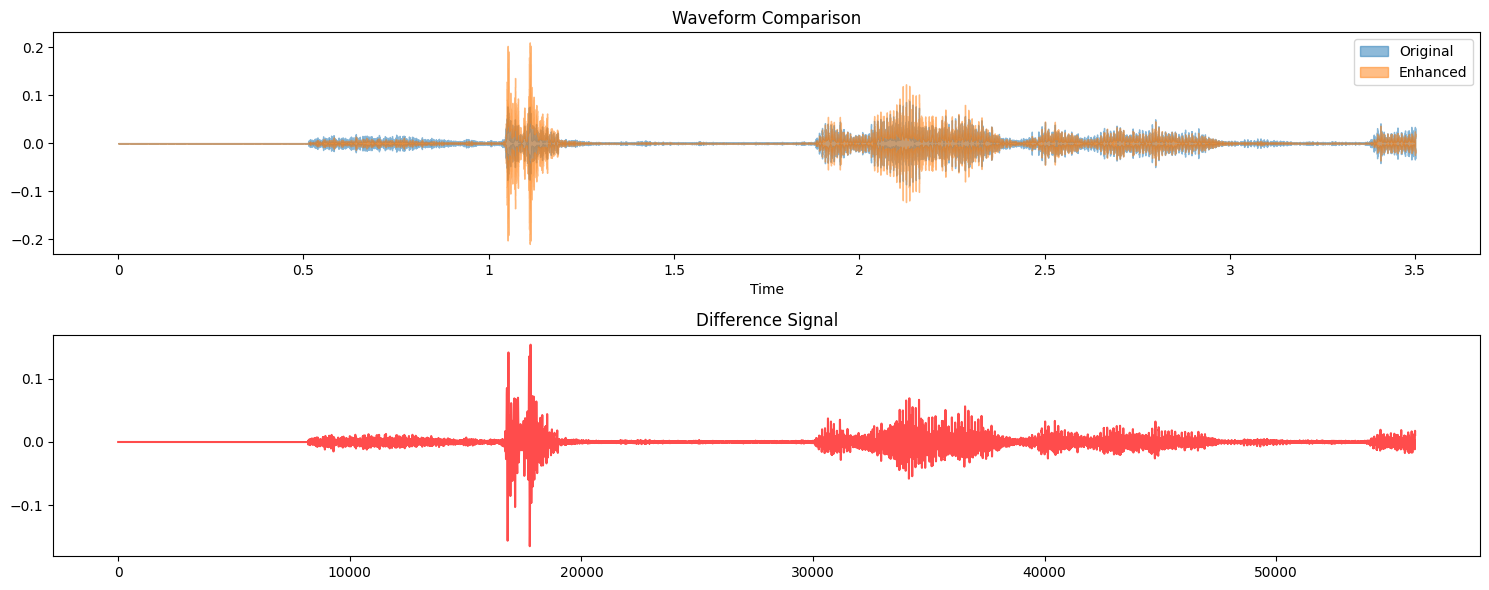

In [23]:
# Time-domain waveform comparison
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
librosa.display.waveshow(original_np, sr=sr_orig, alpha=0.5, label='Original')
librosa.display.waveshow(enhanced_np, sr=sr_orig, alpha=0.5, label='Enhanced')
plt.title('Waveform Comparison')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(enhanced_np - original_np, alpha=0.7, color='red')
plt.title('Difference Signal')
plt.tight_layout()
plt.show()


In [24]:
# Spectrogram comparison
plt.figure(figsize=(15, 10))


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Original Spectrogram')

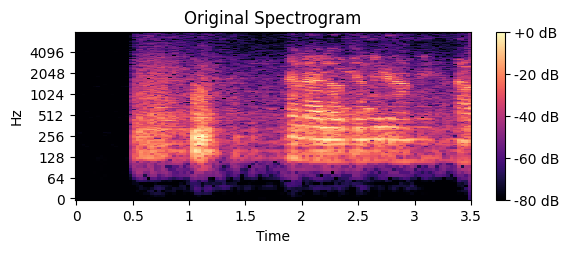

In [25]:
# Original spectrogram
plt.subplot(2, 1, 1)
S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(original_np)), ref=np.max)
librosa.display.specshow(S_orig, sr=sr_orig, y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Spectrogram')

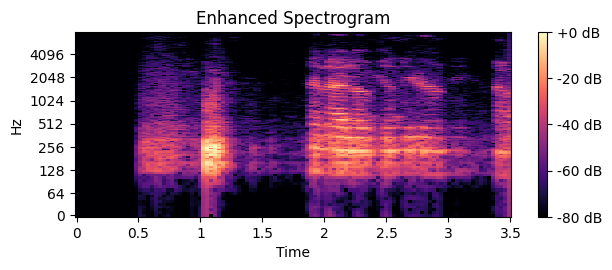

In [26]:
# Enhanced spectrogram
plt.subplot(2, 1, 2)
S_enh = librosa.amplitude_to_db(np.abs(librosa.stft(enhanced_np)), ref=np.max)
librosa.display.specshow(S_enh, sr=sr_orig, y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Enhanced Spectrogram')
plt.tight_layout()
plt.show()


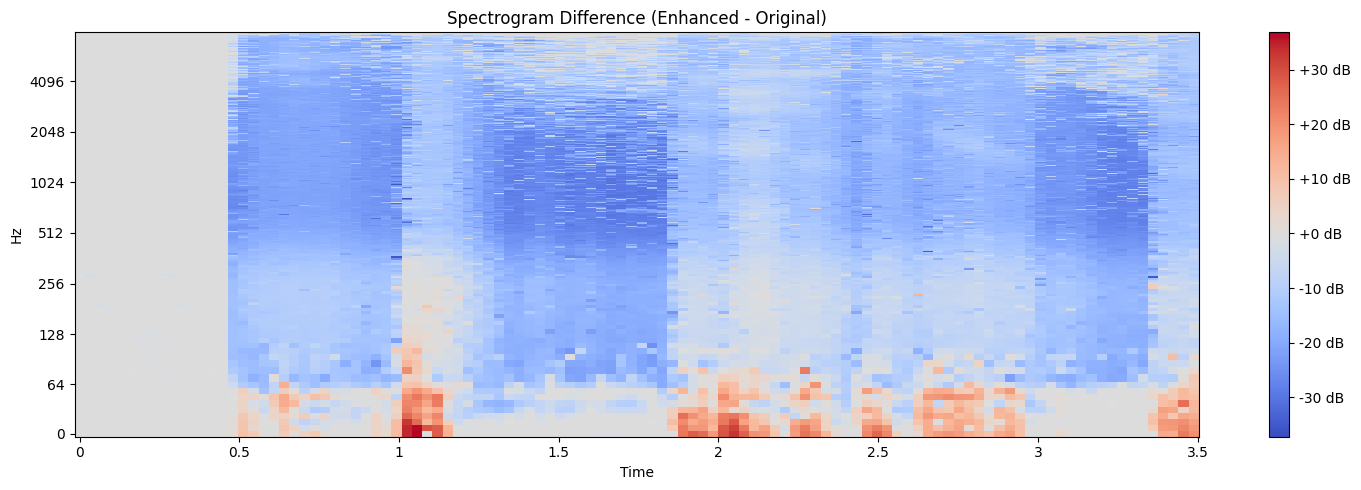

In [27]:
# Difference spectrogram
plt.figure(figsize=(15, 5))
S_diff = S_enh - S_orig
librosa.display.specshow(S_diff, sr=sr_orig, y_axis='log', x_axis='time', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Difference (Enhanced - Original)')
plt.tight_layout()
plt.show()


In [28]:
# Spectral features comparison
def extract_features(y, sr):
    return {
        'spectral_centroid': librosa.feature.spectral_centroid(y=y, sr=sr)[0],
        'spectral_bandwidth': librosa.feature.spectral_bandwidth(y=y, sr=sr)[0],
        'spectral_rolloff': librosa.feature.spectral_rolloff(y=y, sr=sr)[0],
        'zero_crossing_rate': librosa.feature.zero_crossing_rate(y)[0],
        'rms_energy': librosa.feature.rms(y=y)[0]
    }

orig_features = extract_features(original_np, sr_orig)
enh_features = extract_features(enhanced_np, sr_orig)

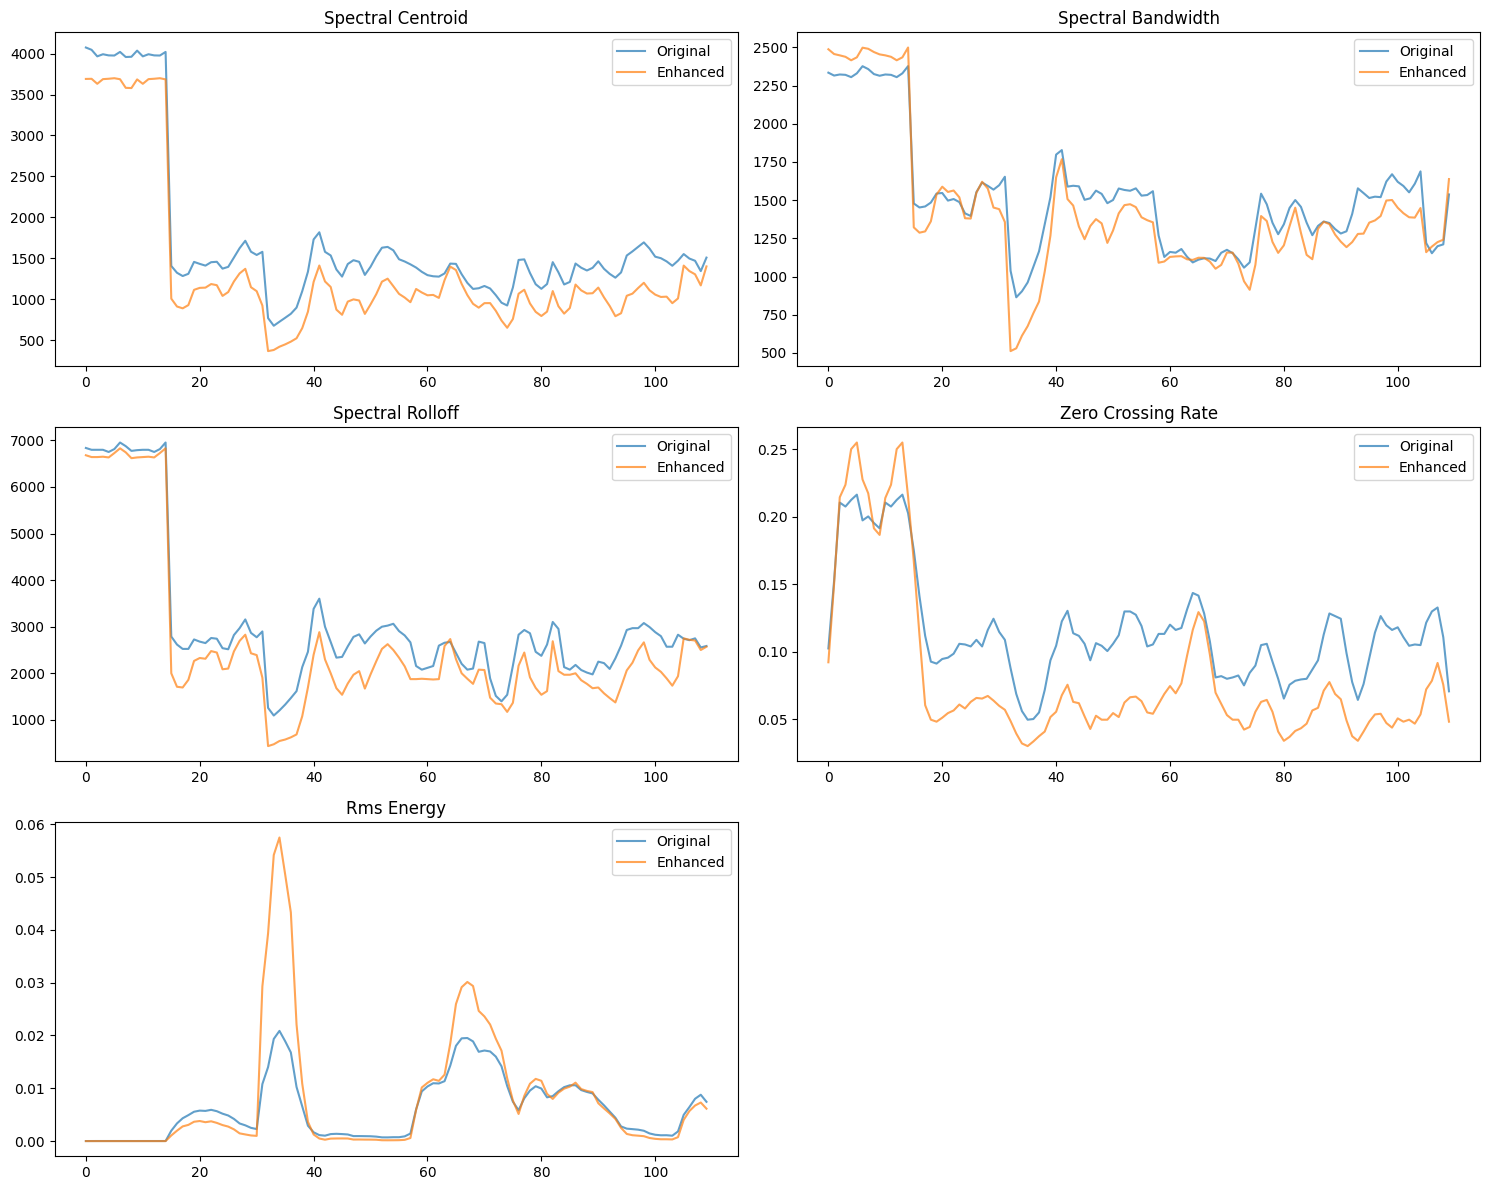

In [29]:
# Feature comparison plots
features = ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zero_crossing_rate', 'rms_energy']
plt.figure(figsize=(15, 12))

for i, feat in enumerate(features, 1):
    plt.subplot(3, 2, i)
    plt.plot(orig_features[feat], label='Original', alpha=0.7)
    plt.plot(enh_features[feat], label='Enhanced', alpha=0.7)
    plt.title(feat.replace('_', ' ').title())
    plt.legend()

plt.tight_layout()
plt.show()

In [30]:
# Quantitative metrics
def calculate_metrics(original, enhanced):
    # Time-domain metrics
    mse = mean_squared_error(original, enhanced)
    snr = 10 * np.log10(np.sum(original**2) / np.sum((original - enhanced)**2))
    
    # Frequency-domain metrics
    orig_fft = np.abs(np.fft.rfft(original))
    enh_fft = np.abs(np.fft.rfft(enhanced))
    freq_mse = mean_squared_error(orig_fft, enh_fft)
    
    # Spectral similarity
    spectral_convergence = np.linalg.norm(orig_fft - enh_fft) / np.linalg.norm(orig_fft)
    
    return {
        'MSE': mse,
        'SNR (dB)': snr,
        'Frequency MSE': freq_mse,
        'Spectral Convergence': spectral_convergence,
        'Energy Ratio': np.sum(enhanced**2) / np.sum(original**2)
    }

metrics = calculate_metrics(original_np, enhanced_np)
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
print(metrics_df)

                         Value
MSE                   0.000111
SNR (dB)             -1.974744
Frequency MSE         3.427743
Spectral Convergence  0.930837
Energy Ratio          2.889673


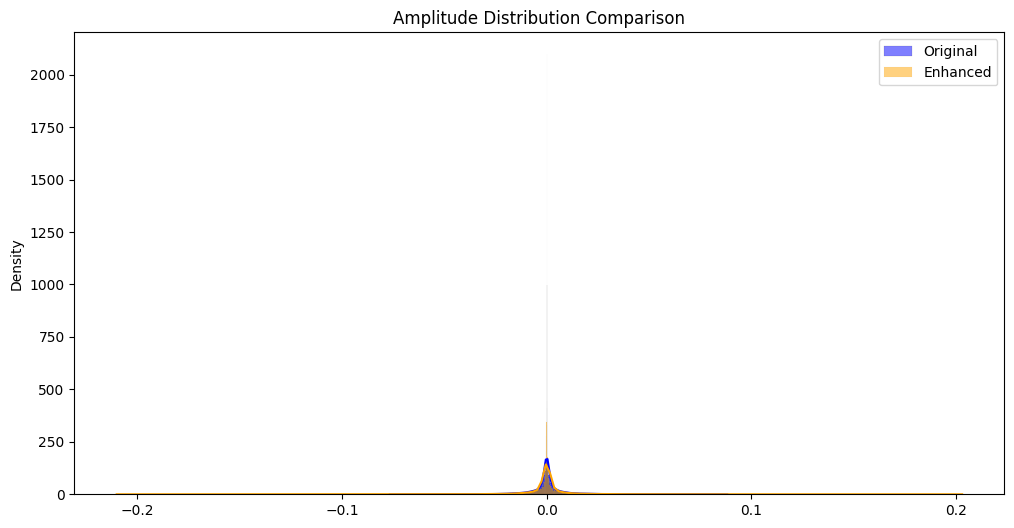

In [31]:
# Histogram comparison
plt.figure(figsize=(12, 6))
sns.histplot(original_np, color='blue', label='Original', alpha=0.5, kde=True, stat='density')
sns.histplot(enhanced_np, color='orange', label='Enhanced', alpha=0.5, kde=True, stat='density')
plt.title('Amplitude Distribution Comparison')
plt.legend()
plt.show()


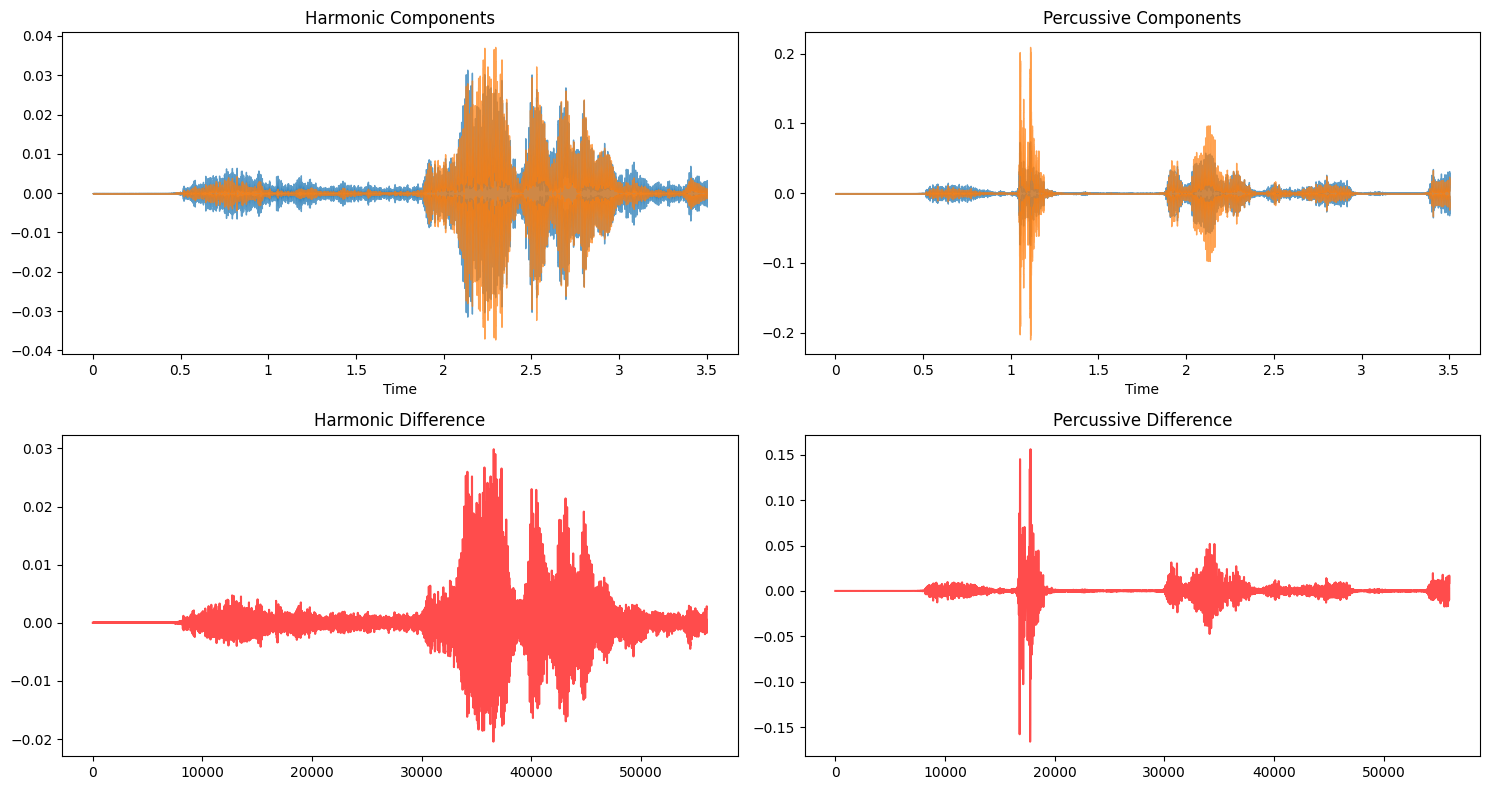

In [32]:
# Harmonic-percussive separation comparison
plt.figure(figsize=(15, 8))

y_harm_orig, y_perc_orig = librosa.effects.hpss(original_np)
y_harm_enh, y_perc_enh = librosa.effects.hpss(enhanced_np)

plt.subplot(2, 2, 1)
librosa.display.waveshow(y_harm_orig, sr=sr_orig, alpha=0.7, label='Original')
librosa.display.waveshow(y_harm_enh, sr=sr_orig, alpha=0.7, label='Enhanced')
plt.title('Harmonic Components')

plt.subplot(2, 2, 2)
librosa.display.waveshow(y_perc_orig, sr=sr_orig, alpha=0.7, label='Original')
librosa.display.waveshow(y_perc_enh, sr=sr_orig, alpha=0.7, label='Enhanced')
plt.title('Percussive Components')

plt.subplot(2, 2, 3)
plt.plot(y_harm_enh - y_harm_orig, alpha=0.7, color='red')
plt.title('Harmonic Difference')

plt.subplot(2, 2, 4)
plt.plot(y_perc_enh - y_perc_orig, alpha=0.7, color='red')
plt.title('Percussive Difference')

plt.tight_layout()
plt.show()


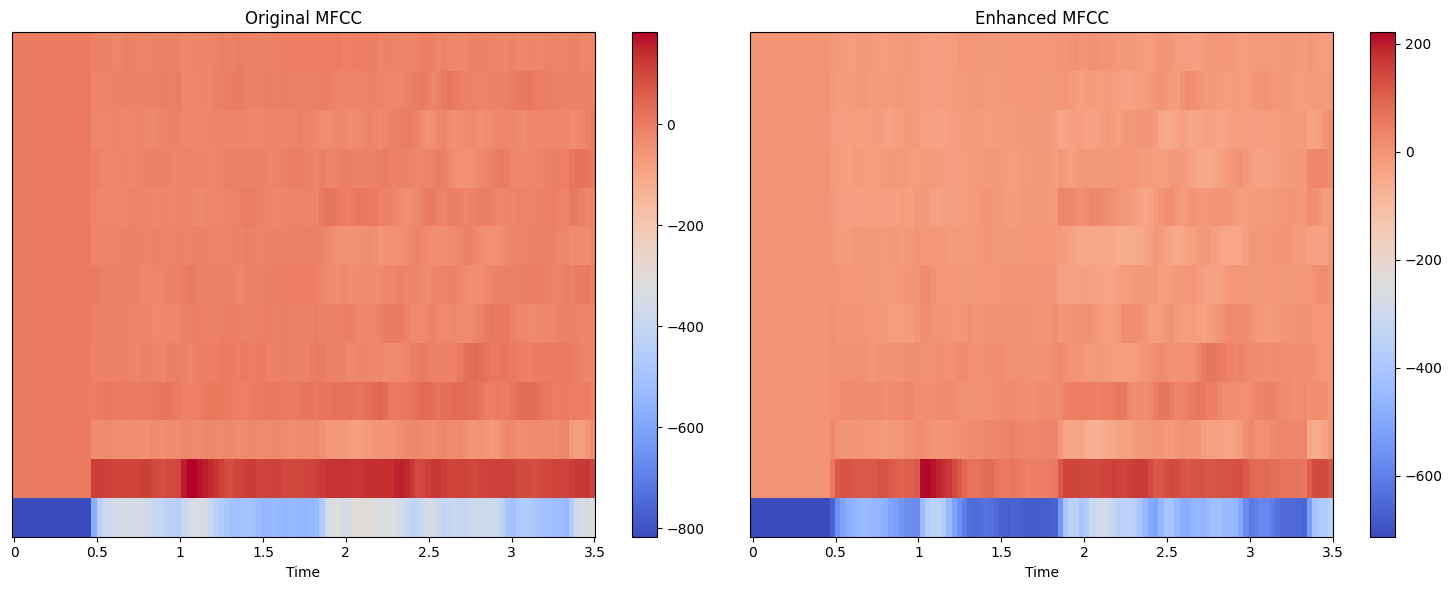

In [33]:
# MFCC comparison
plt.figure(figsize=(15, 6))

mfcc_orig = librosa.feature.mfcc(y=original_np, sr=sr_orig, n_mfcc=13)
mfcc_enh = librosa.feature.mfcc(y=enhanced_np, sr=sr_orig, n_mfcc=13)

plt.subplot(1, 2, 1)
librosa.display.specshow(mfcc_orig, x_axis='time', sr=sr_orig)
plt.colorbar()
plt.title('Original MFCC')

plt.subplot(1, 2, 2)
librosa.display.specshow(mfcc_enh, x_axis='time', sr=sr_orig)
plt.colorbar()
plt.title('Enhanced MFCC')

plt.tight_layout()
plt.show()

In [37]:
# Improved reporting section
def create_metrics_df(metrics_dict):
    """Convert metrics dictionary to properly formatted DataFrame"""
    df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Value'])
    df.index.name = 'Metric'
    return df

In [41]:
# Construct the report dictionary
report = {
	'audio_metrics': metrics,
	'feature_comparison': {
		'original_mean': {feat: np.mean(orig_features[feat]) for feat in features},
		'enhanced_mean': {feat: np.mean(enh_features[feat]) for feat in features}
	}
}


In [42]:


# Create proper DataFrames for each section
audio_metrics_df = create_metrics_df(report['audio_metrics'])
feature_comparison_df = pd.DataFrame(report['feature_comparison']).T
feature_comparison_df.index.name = 'Feature'

# Display metrics with better formatting
print("AUDIO METRICS:")
display(audio_metrics_df.style.background_gradient(cmap='Blues'))

print("\nFEATURE COMPARISON:")
display(feature_comparison_df.style.background_gradient(cmap='Reds'))

AUDIO METRICS:


,Value
Metric,
MSE,0.000111
SNR (dB),-1.974744
Frequency MSE,3.427743
Spectral Convergence,0.930837
Energy Ratio,2.889673



FEATURE COMPARISON:


,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms_energy
Feature,,,,,
original_mean,1717.465634,1521.614123,3089.275568,0.115598,0.006049
enhanced_mean,1372.358411,1433.968025,2602.414773,0.080744,0.007963


<Figure size 1200x600 with 0 Axes>

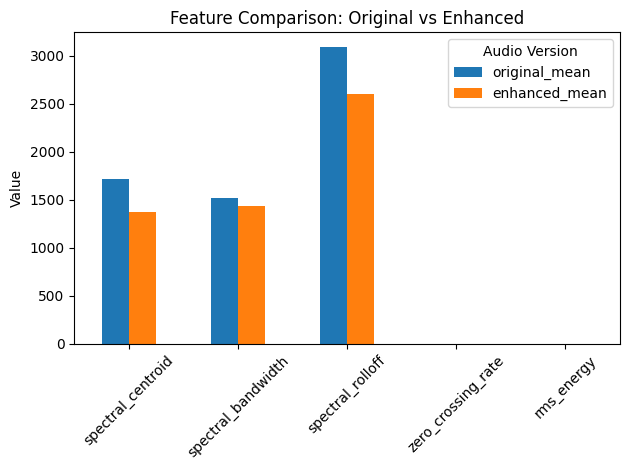

<Figure size 1000x500 with 0 Axes>

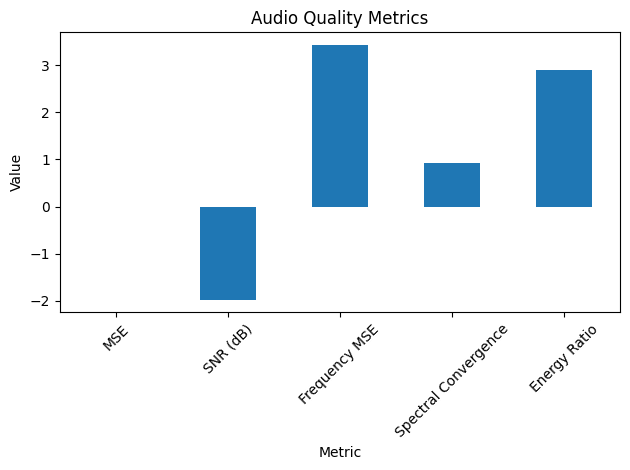

In [44]:
# Plot feature comparison
plt.figure(figsize=(12, 6))
feature_comparison_df.T[['original_mean', 'enhanced_mean']].plot(kind='bar', rot=45)
plt.title('Feature Comparison: Original vs Enhanced')
plt.ylabel('Value')
plt.legend(title='Audio Version')
plt.tight_layout()
plt.show()

# Plot metric improvements
plt.figure(figsize=(10, 5))
audio_metrics_df.plot(kind='bar', legend=False)
plt.title('Audio Quality Metrics')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()